In [252]:
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree

# Find nearest IDs

For each POLYGON find the 3 nearest POLYGONS for the same crop type in a different year.

## 2018 values for 2017 fields

In [2]:
# Import 2017 clean
clean_17 = gpd.read_file(".\\poljine_SHP\\ZV2017_d96tm_clean_ids.shp")
clean_18 = gpd.read_file(".\\poljine_SHP\\ZV2018_d96tm_clean_ids.shp")

In [3]:
print(clean_17.head(), '\n--------')
print(clean_18.head())

#clean_17.head(3)

   id_17  GERK_PID  POLJINA_ID  RABA_ID  POVR_GERK_ SIFRA_KMRS OBRAZEC  \
0      0   2537988     2104906     1100  19308.9997        801      GP   
1      1   2537988     2104908     1100  19308.9997        005      GP   
2      2   2537988     2104910     1100  19308.9997        203      GP   
3      3   1143420     2105003     1100   8277.3796        801      GP   
4      4   3077991     2652377     1211  14987.7976        100      GP   

   INTERSECT     POVR_ar  REGIJA  \
0          0   57.930456       5   
1          0   30.520097       5   
2          0   26.799442       5   
3          0   40.952670       5   
4          0  149.877976       4   

                                            geometry  
0  POLYGON ((547508.347 86829.736, 547545.426 868...  
1  POLYGON ((547497.850 86785.076, 547578.847 867...  
2  POLYGON ((547599.139 86850.730, 547670.666 868...  
3  POLYGON ((547165.958 85941.243, 547179.112 859...  
4  POLYGON ((419052.089 80240.803, 419056.851 802...   
-------

In [368]:
# Get statistics on KMRS values (crop type)
kmrs_list = clean_17.SIFRA_KMRS.value_counts()
# Only select values that have more than 1000 occurances 
kmrs_list = kmrs_list[kmrs_list > 1000]
print(kmrs_list)
print(kmrs_list.shape)

204    338342
005     47231
801     38115
809     33767
006     31742
100     19479
699     18649
203     16087
201     12819
208      8035
807      7903
013      7214
112      7125
405      6293
207      6220
020      5505
814      5216
206      5070
004      4009
402      3270
222      3262
555      2765
611      2545
111      2468
008      2341
506      2220
030      2073
811      1922
802      1907
812      1613
009      1558
800      1474
026      1372
803      1006
Name: SIFRA_KMRS, dtype: int64
(34,)


In [376]:
# This is the number of data points we lose, if we focus only on those with more than 1000 occurances
print(clean_17.SIFRA_KMRS.value_counts().to_list())
print(clean_17.SIFRA_KMRS.value_counts().shape)

aaa = clean_17.SIFRA_KMRS.value_counts()
aaa[aaa < 1000].sum()

[338342, 47231, 38115, 33767, 31742, 19479, 18649, 16087, 12819, 8035, 7903, 7214, 7125, 6293, 6220, 5505, 5216, 5070, 4009, 3270, 3262, 2765, 2545, 2468, 2341, 2220, 2073, 1922, 1907, 1613, 1558, 1474, 1372, 1006, 881, 877, 854, 820, 661, 545, 450, 442, 429, 424, 390, 384, 379, 305, 288, 285, 276, 236, 236, 212, 212, 203, 198, 193, 182, 182, 173, 171, 162, 148, 132, 132, 128, 108, 102, 101, 92, 77, 75, 67, 67, 63, 59, 58, 55, 50, 44, 43, 42, 40, 35, 35, 33, 30, 30, 28, 28, 28, 27, 27, 27, 26, 25, 24, 24, 23, 22, 21, 21, 19, 19, 18, 17, 17, 12, 12, 12, 10, 10, 9, 8, 8, 7, 7, 7, 6, 6, 6, 5, 5, 5, 5, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1]
(146,)


13521

In [7]:
kmrs = "204"
# Filter dataframe to include only this crop type
filter_17 = clean_17["SIFRA_KMRS"] == kmrs
filter_18 = clean_18["SIFRA_KMRS"] == kmrs

# Filtered data frames
data_17 = clean_17[filter_17]
data_18 = clean_18[filter_18]


In [8]:
filter_17

0         False
1         False
2         False
3         False
4         False
          ...  
664133     True
664134     True
664135     True
664136     True
664137     True
Name: SIFRA_KMRS, Length: 664138, dtype: bool

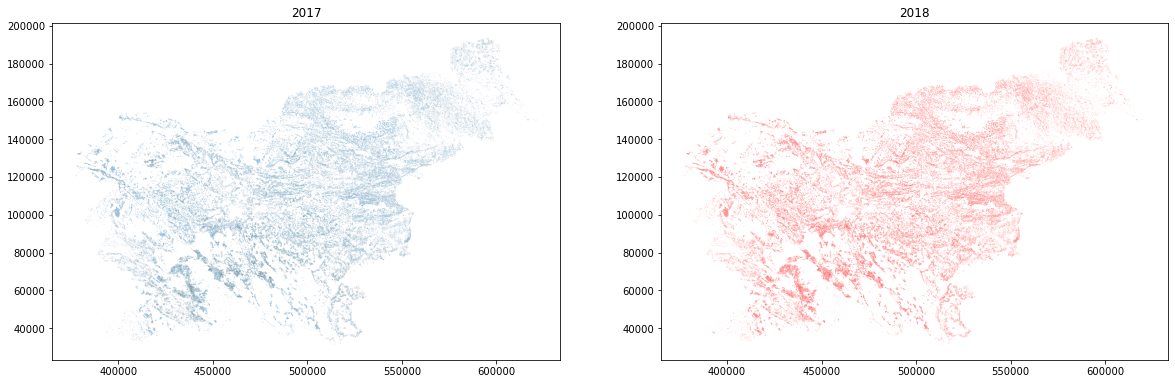

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes=plt.subplots(nrows=1, ncols=2, figsize=(20,10))

# Plot buildings
filter_17.plot(ax=axes[0], markersize=0.2, alpha=0.5)
axes[0].set_title('2017')

# Plot stops
filter_18.plot(ax=axes[1], markersize=0.2, alpha=0.5, color='red')
axes[1].set_title('2018');

In [278]:
# (1) Create Df copy for output and
# (2) add new columns for that will be use for finding nearest neighbours
output = clean_17.copy()
ktree_labels = ["dist0", "near0", "near1", "near2"]
for lb in ktree_labels:
    output[lb] = None
output.head(2)

,id_17,GERK_PID,POLJINA_ID,RABA_ID,POVR_GERK_,SIFRA_KMRS,OBRAZEC,INTERSECT,POVR_ar,REGIJA,geometry,dist0,near0,near1,near2
0,0,2537988,2104906,1100,19308.9997,801,GP,0,57.930456,5,"POLYGON ((547508.347 86829.736, 547545.426 868...",None,None,None,None
1,1,2537988,2104908,1100,19308.9997,005,GP,0,30.520097,5,"POLYGON ((547497.850 86785.076, 547578.847 867...",None,None,None,None


# Use k-tree to find nearest neighbours

This part of the code uses BellTree from sci-kit learn for finding top three nearest neighbours for the selected crop type. Inputs are GeoDataFrames filtered for the selected crop type.

In [141]:
%%time

kmrs = "006"
# Filter dataframe to include only this crop type
filter_17 = clean_17["SIFRA_KMRS"] == kmrs
filter_18 = clean_18["SIFRA_KMRS"] == kmrs

# Filtered data frames
data_17 = clean_17[filter_17]
data_18 = clean_18[filter_18]

Wall time: 224 ms


In [142]:
print(f"Fields in 2017 | {len(data_17.index)}")
print(f"Fields in 2018 | {len(data_18.index)}")

Fields in 2017 | 31742
Fields in 2018 | 33305


In [143]:
%%time

# How centroids method works?
data_17.centroid

Wall time: 1.07 s


16         POINT (489977.747 92914.858)
18         POINT (489638.130 92954.095)
23         POINT (488100.513 84783.084)
201        POINT (498162.233 95724.956)
281        POINT (459161.708 94447.346)
                      ...              
664086    POINT (493756.812 128369.072)
664097    POINT (466883.496 103526.865)
664098    POINT (471013.823 103847.263)
664120     POINT (513133.572 68570.436)
664129    POINT (434132.924 107650.244)
Length: 31742, dtype: geometry

In [144]:
#closest_stops = nearest_neighbor(buildings, stops, return_dist=True)
left_gdf = data_17
right_gdf = data_18

In [145]:
%%time

# Calculate centroid and parse coordinates
left_coords = np.array(left_gdf.centroid.apply(lambda geom: (geom.x, geom.y)).to_list())
right_coords = np.array(right_gdf.centroid.apply(lambda geom: (geom.x, geom.y)).to_list())

print(left_coords)
print("\n")
print(right_coords)

# Also create key, so we will be able to match the resulting indices to the ID values from the right data frame

[[489977.74677258  92914.85791384]
 [489638.12975584  92954.09462024]
 [488100.51302736  84783.08357627]
 ...
 [471013.82273047 103847.2629452 ]
 [513133.57210006  68570.43630921]
 [434132.92405596 107650.24444525]]


[[570382.68279766 166328.81857734]
 [572392.51228002 165737.28545625]
 [571867.08113408 165945.90676626]
 ...
 [473402.35843399 112667.33561789]
 [474061.56829372 112573.78324992]
 [486149.66632218 115590.29875203]]
Wall time: 3.81 s


In [146]:
%%time

# Find the nearest points
# -----------------------
src_points=left_coords
candidates=right_coords

# Set this to 3 to find the 3 closest
k_neighbors=3

# Create tree from the candidate points (make sure you use arithmetic distance)
tree = BallTree(candidates, leaf_size=15)

Wall time: 22.2 ms


In [147]:
%%time

# Find closest points and distances
distances, indices = tree.query(src_points, k=k_neighbors)

Wall time: 395 ms


In [148]:
print(f"Distances shape = {distances.shape}")
print(distances)
print("\n")
print(f"Indices shape = {indices.shape}")
print(indices)

Distances shape = (31742, 3)
[[5.05894953e+01 6.45216609e+02 6.88193708e+02]
 [2.96208636e+02 3.47313588e+02 3.58329335e+02]
 [2.08150781e+02 7.99098812e+02 8.38641695e+02]
 ...
 [1.31736956e+02 2.19909923e+02 2.45839717e+02]
 [1.72579825e-09 4.26036025e+02 4.29137526e+02]
 [1.58881645e+02 3.15448376e+02 3.54068514e+02]]


Indices shape = (31742, 3)
[[14599 22240 14594]
 [14599 22240 14594]
 [21968 21957 22003]
 ...
 [10776 10778 31855]
 [31239 25171 31238]
 [ 5570  5572 31250]]


In [149]:
np.where(distances[:, 0] < 5)[0].shape

(10828,)

# Populate output dataframe

In [247]:
# TODO: THIS NEEDS TO BE A FUNCTION THAT IS USED ON THE OUTPUT FROM k-tree

%%time

original_shape = indices.shape
print(f" Initial shape: {indices.shape}")
print(indices[:3, :])
my_index = indices.flatten()

print(f" Flatten: {my_index.shape}")
print(my_index[:6])

new_ids = data_18["id_18"].reset_index(drop=True).iloc[my_index].to_numpy()
print(f" After id mapping: {new_ids.shape}")
print(new_ids[:6])

ids_18 = new_ids.reshape(original_shape)
print(f" Finally: {ids_18.shape}")
print(ids_18[:3, :])

 Initial shape: (31742, 3)
[[14599 22240 14594]
 [14599 22240 14594]
 [21968 21957 22003]]
 Flatten: (95226,)
[14599 22240 14594 14599 22240 14594]
 After id mapping: (95226,)
[338196 500430 338038 338196 500430 338038]
 Finally: (31742, 3)
[[338196 500430 338038]
 [338196 500430 338038]
 [496888 496676 497283]]
Wall time: 6.37 ms


In [282]:
output.loc[filter_17, ("dist0")] = distances[:, 0].tolist()
output.loc[filter_17, ("near0", "near1", "near2")] = ids_18.tolist()

#= distances[:, 0].tolist()

In [283]:
output.loc[filter_17].head(6)

,id_17,GERK_PID,POLJINA_ID,RABA_ID,POVR_GERK_,SIFRA_KMRS,OBRAZEC,INTERSECT,POVR_ar,REGIJA,geometry,dist0,near0,near1,near2
16,16,2461559,2105020,1100,9255.4505,006,GP,0,92.554505,5,"POLYGON ((489995.821 92893.710, 490002.679 929...",50.589495,338196,500430,338038
18,18,2461557,2105022,1100,2115.2159,006,GP,0,21.152159,5,"POLYGON ((489657.872 92955.388, 489662.069 929...",296.208636,338196,500430,338038
23,23,4225226,2107171,1100,2472.8875,006,GP,0,24.728875,5,"POLYGON ((488043.818 84757.899, 488041.382 847...",208.150781,496888,496676,497283
201,201,2308649,2105596,1100,3358.4170,006,GP,0,15.170694,5,"POLYGON ((498119.067 95785.023, 498159.830 957...",405.213466,655557,655559,626770
281,281,4874755,2105370,1100,4826.3754,006,GP,0,48.263754,5,"POLYGON ((459033.027 94390.942, 459128.874 944...",0.0,543257,545334,269841
285,285,3641084,2105374,1100,4262.4777,006,GP,0,42.624777,5,"POLYGON ((458806.615 94258.777, 458804.084 942...",0.0,543261,330106,542684


In [284]:
output

,id_17,GERK_PID,POLJINA_ID,RABA_ID,POVR_GERK_,SIFRA_KMRS,OBRAZEC,INTERSECT,POVR_ar,REGIJA,geometry,dist0,near0,near1,near2
0,0,2537988,2104906,1100,19308.9997,801,GP,0,57.930456,5,"POLYGON ((547508.347 86829.736, 547545.426 868...",None,None,None,None
1,1,2537988,2104908,1100,19308.9997,005,GP,0,30.520097,5,"POLYGON ((547497.850 86785.076, 547578.847 867...",None,None,None,None
2,2,2537988,2104910,1100,19308.9997,203,GP,0,26.799442,5,"POLYGON ((547599.139 86850.730, 547670.666 868...",None,None,None,None
3,3,1143420,2105003,1100,8277.3796,801,GP,0,40.952670,5,"POLYGON ((547165.958 85941.243, 547179.112 859...",None,None,None,None
4,4,3077991,2652377,1211,14987.7976,100,GP,0,149.877976,4,"POLYGON ((419052.089 80240.803, 419056.851 802...",None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664133,664133,1892284,2976726,1300,8760.9728,204,GP,0,87.609728,2,"POLYGON ((434921.542 108572.694, 434922.432 10...",None,None,None,None
664134,664134,3588000,2976727,1300,7807.7304,204,GP,0,78.077304,2,"POLYGON ((434747.327 108244.216, 434730.310 10...",None,None,None,None
664135,664135,1646627,2976728,1300,7559.2166,204,GP,0,75.592166,2,"POLYGON ((432921.938 108920.374, 432931.875 10...",None,None,None,None
664136,664136,3588612,2976729,1300,6120.1665,204,GP,0,61.201665,2,"POLYGON ((435669.945 108166.760, 435723.973 10...",None,None,None,None


# Populate with values from the 2018 CSV file based on the selcted indices

This workflow works! It is currently only implemented on a subset of data. Also use 

In [255]:
%%time
csv_18 = pd.read_csv(".\\csvs\\ZV2018_d96tm_clean_evi2.csv")

Wall time: 4.97 s


In [262]:
print(f"CSV shape: {csv_18.shape}")
print(f"Output DF shape: {output.shape}")

CSV shape: (680698, 51)
Output DF shape: (664138, 15)


In [264]:
csv_18.head()

,index,GERK_PID,RABA_ID,POVR_GERK_,POLJINA_ID,SIFRA_KMRS,OBRAZEC,POVR_ar,INTERSECT,evi2_04_01,...,evi2_09_13,evi2_09_18,evi2_09_23,evi2_09_28,evi2_10_03,evi2_10_08,evi2_10_13,evi2_10_18,evi2_10_23,evi2_10_28
0,0,2439387,1300,31637.2652,3280114,204,GP,316.379280,0,0.099511,...,0.527768,0.563208,NaN,0.571407,NaN,NaN,NaN,NaN,0.411956,NaN
1,1,4896286,1100,1187.8658,3280115,405,GP,11.878907,0,NaN,...,0.490225,0.411284,NaN,0.359409,NaN,NaN,NaN,NaN,0.366518,NaN
2,2,4896302,1300,31987.1334,3280116,204,GP,319.878034,0,NaN,...,0.515570,0.525003,NaN,0.531735,NaN,NaN,NaN,NaN,0.431187,NaN
3,3,2439736,1300,7075.6430,3280117,204,GP,70.757911,0,NaN,...,0.519779,0.483743,NaN,0.563268,NaN,NaN,NaN,NaN,0.561050,NaN
4,4,2439393,1300,5647.2772,3280118,204,GP,56.473954,0,NaN,...,0.439925,0.473259,NaN,0.557590,NaN,NaN,NaN,NaN,0.459145,NaN


In [298]:
far_fields = output["dist0"] > 10
far_ids = output.loc[far_fields, ("near0")].to_numpy()

csv_18.loc[far_ids, "evi2_04_01":"evi2_10_28"]

#gpd.concat([output[far_fields], csv_18.loc[far_ids, "evi2_04_01":"evi2_10_28"]].reset_index(), axis=1)

,evi2_04_01,evi2_04_06,evi2_04_11,evi2_04_16,evi2_04_21,evi2_04_26,evi2_05_01,evi2_05_06,evi2_05_11,evi2_05_16,...,evi2_09_13,evi2_09_18,evi2_09_23,evi2_09_28,evi2_10_03,evi2_10_08,evi2_10_13,evi2_10_18,evi2_10_23,evi2_10_28
338196,NaN,0.150037,0.391821,0.292473,0.528713,NaN,NaN,0.364825,NaN,NaN,...,NaN,0.489198,NaN,0.466588,NaN,NaN,NaN,NaN,0.418239,NaN
338196,NaN,0.150037,0.391821,0.292473,0.528713,NaN,NaN,0.364825,NaN,NaN,...,NaN,0.489198,NaN,0.466588,NaN,NaN,NaN,NaN,0.418239,NaN
496888,NaN,0.196139,0.315566,0.085442,0.470143,NaN,NaN,NaN,NaN,NaN,...,NaN,0.473208,NaN,0.320255,NaN,NaN,NaN,NaN,0.263869,NaN
655557,NaN,0.184725,0.237031,0.141253,0.280234,NaN,NaN,0.359237,NaN,NaN,...,NaN,0.321377,NaN,0.296444,NaN,NaN,NaN,NaN,0.337294,NaN
630550,NaN,0.119855,0.137899,NaN,0.173390,NaN,NaN,NaN,NaN,NaN,...,NaN,0.226104,NaN,0.243244,NaN,NaN,NaN,NaN,0.210953,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616819,0.259236,0.412093,0.298172,NaN,0.494613,NaN,NaN,0.354367,0.272441,NaN,...,NaN,0.315890,NaN,0.217909,NaN,NaN,NaN,NaN,NaN,NaN
598352,0.149341,0.288268,NaN,NaN,0.558224,NaN,NaN,0.485104,0.410489,NaN,...,NaN,0.557639,NaN,0.552741,0.588888,NaN,NaN,NaN,0.639964,NaN
222842,NaN,0.214513,NaN,NaN,0.366796,NaN,NaN,0.236413,NaN,0.281214,...,NaN,0.387515,NaN,0.367529,NaN,NaN,NaN,NaN,NaN,NaN
222646,NaN,0.367678,0.387081,NaN,0.594929,NaN,NaN,0.476535,NaN,0.396419,...,NaN,0.248065,NaN,0.238332,NaN,NaN,NaN,NaN,NaN,NaN


In [306]:
output.head(1)

,id_17,GERK_PID,POLJINA_ID,RABA_ID,POVR_GERK_,SIFRA_KMRS,OBRAZEC,INTERSECT,POVR_ar,REGIJA,geometry,dist0,near0,near1,near2
0,0,2537988,2104906,1100,19308.9997,801,GP,0,57.930456,5,"POLYGON ((547508.347 86829.736, 547545.426 868...",None,None,None,None


In [355]:
melted = output.loc[far_fields, ["id_17", "dist0", "near0", "near1", "near2"]].melt(id_vars=["id_17", "dist0"])

In [340]:
melted

,id_17,dist0,variable,value
0,16,50.589495,near1,500430
1,18,296.208636,near1,500430
2,23,208.150781,near1,496676
3,201,405.213466,near1,655559
4,395,107.877546,near1,627567
...,...,...,...,...
40557,663936,182.196462,near2,652444
40558,664030,106.942931,near2,598353
40559,664097,50.569568,near2,104641
40560,664098,131.736956,near2,661698


In [356]:
extracted_values = csv_18.loc[melted.value.to_numpy(), "evi2_04_01":"evi2_10_28"].reset_index(drop=True)
my_columns = extracted_values.columns.to_list()

In [364]:
before_pivot = pd.concat([melted, extracted_values], axis=1)
before_pivot = before_pivot.drop(columns=["value", "dist0"])
before_pivot.head(3)

,id_17,variable,evi2_04_01,evi2_04_06,evi2_04_11,evi2_04_16,evi2_04_21,evi2_04_26,evi2_05_01,evi2_05_06,...,evi2_09_13,evi2_09_18,evi2_09_23,evi2_09_28,evi2_10_03,evi2_10_08,evi2_10_13,evi2_10_18,evi2_10_23,evi2_10_28
0,16,near0,NaN,0.150037,0.391821,0.292473,0.528713,NaN,NaN,0.364825,...,NaN,0.489198,NaN,0.466588,NaN,NaN,NaN,NaN,0.418239,NaN
1,18,near0,NaN,0.150037,0.391821,0.292473,0.528713,NaN,NaN,0.364825,...,NaN,0.489198,NaN,0.466588,NaN,NaN,NaN,NaN,0.418239,NaN
2,23,near0,NaN,0.196139,0.315566,0.085442,0.470143,NaN,NaN,NaN,...,NaN,0.473208,NaN,0.320255,NaN,NaN,NaN,NaN,0.263869,NaN


In [362]:
before_pivot.loc[before_pivot.id_17 == 16, "evi2_04_06"].mean()

0.14113082488377882

In [366]:
before_pivot.pivot_table(
    values=my_columns,
    index=['id_17'],
    aggfunc=np.nanmean
)

,evi2_04_01,evi2_04_06,evi2_04_11,evi2_04_16,evi2_04_21,evi2_04_26,evi2_05_01,evi2_05_06,evi2_05_11,evi2_05_16,...,evi2_09_13,evi2_09_18,evi2_09_23,evi2_09_28,evi2_10_03,evi2_10_08,evi2_10_13,evi2_10_18,evi2_10_23,evi2_10_28
id_17,,,,,,,,,,,,,,,,,,,,,
16,NaN,0.141131,0.266202,0.236801,0.351186,NaN,NaN,0.317133,NaN,NaN,...,NaN,0.367988,NaN,0.350229,NaN,NaN,NaN,NaN,0.280089,NaN
18,NaN,0.141131,0.266202,0.236801,0.351186,NaN,NaN,0.317133,NaN,NaN,...,NaN,0.367988,NaN,0.350229,NaN,NaN,NaN,NaN,0.280089,NaN
23,NaN,0.228823,0.260088,0.085676,0.359559,NaN,NaN,NaN,NaN,NaN,...,NaN,0.372986,NaN,0.270796,NaN,NaN,NaN,NaN,0.299079,NaN
201,NaN,0.311366,0.288621,0.164589,0.381424,NaN,NaN,0.347029,NaN,0.215658,...,NaN,0.391412,NaN,0.296577,NaN,NaN,NaN,NaN,0.368896,NaN
395,NaN,0.184139,0.205960,NaN,0.268887,NaN,NaN,NaN,NaN,NaN,...,NaN,0.281229,NaN,0.248444,NaN,NaN,NaN,NaN,0.262106,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663936,0.286117,0.484480,0.298172,NaN,0.573066,NaN,NaN,0.495128,0.275661,NaN,...,NaN,0.311861,NaN,0.223172,NaN,NaN,NaN,0.129302,NaN,NaN
664030,0.225228,0.352807,NaN,NaN,0.521515,NaN,NaN,0.427242,0.418443,NaN,...,NaN,0.461804,NaN,0.508892,0.502715,NaN,NaN,NaN,0.507064,NaN
664097,NaN,0.328294,NaN,NaN,0.393022,NaN,NaN,0.235793,NaN,0.317996,...,NaN,0.390955,NaN,0.380401,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#TODO: ZDAJ PA POISCI VREDNOSTI ZA TISTE KI SE PREKRIVCAJO (dist < 10 m)